# TODO

1. save the output of every embedding

2. run tsne for vis. in 2d plot

3. color scatter plot w.r.t. diff

In [1]:
# config
import torch
import torch.nn as nn

# hyperparameters
gpu_id = 0 if torch.cuda.is_available() else -1
device = torch.device('cuda:0')
max_seq_len = 100
train_ratio = .8
valid_ratio = .1
hidden_size = 512
output_size = 1
num_head = 8
num_encoder = 12
use_leakyrelu = True
dropout_p = .1
learning_rate = 0.001
grad_acc = True
grad_acc_iter = 8

batch_size = 64
n_epochs = 2

In [2]:
# dataloader : diff
from dataloaders.assist2009_pid_diff_loader import ASSIST2009_PID_DIFF
from utils import pid_diff_collate_fn
from torch.utils.data import DataLoader, random_split

dataset = ASSIST2009_PID_DIFF(max_seq_len)
num_q = dataset.num_q
num_r = dataset.num_r
num_pid = dataset.num_pid
num_diff = dataset.num_diff
collate = pid_diff_collate_fn

train_size = int( len(dataset) * train_ratio * (1 - valid_ratio))
valid_size = int( len(dataset) * train_ratio * valid_ratio)
test_size = len(dataset) - (train_size + valid_size)

train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [ train_size, valid_size, test_size ]
    )

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True, # train_loader use shuffle
    collate_fn = collate
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle = False, # valid_loader don't use shuffle
    collate_fn = collate
)
test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False, # test_loader don't use shuffle
    collate_fn = collate
)

from models.monaconvbert4kt_plus_diff import MonaConvBert4ktPlusDiff

model = MonaConvBert4ktPlusDiff(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_diff=num_diff,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=16, # TODO : 16 인데 실제로는 8 임, head_ratio 확인
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p
).to(device)

model_path = '/root/BiDKT/model_records/assist09.pth'
model_dict = torch.load(model_path)
model.load_state_dict(model_dict['model'])

<All keys matched successfully>

In [3]:
# dataloader : normal
from dataloaders.assist2009_pid_loader import ASSIST2009_PID
from trainers.monaconvbert4kt_plus_trainer import MonaConvBert4ktPlusTrainer
from utils import pid_collate_fn
from torch.utils.data import DataLoader, random_split

dataset = ASSIST2009_PID(max_seq_len)  
num_q = dataset.num_q
num_r = dataset.num_r
num_pid = dataset.num_pid
num_diff = None
collate = pid_collate_fn

train_size = int( len(dataset) * train_ratio * (1 - valid_ratio))
valid_size = int( len(dataset) * train_ratio * valid_ratio)
test_size = len(dataset) - (train_size + valid_size)

train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [ train_size, valid_size, test_size ]
)

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True, # train_loader use shuffle
    collate_fn = collate
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle = False, # valid_loader don't use shuffle
    collate_fn = collate
)
test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False, # test_loader don't use shuffle
    collate_fn = collate
)

from models.monaconvbert4kt_plus import MonaConvBert4ktPlus

model = MonaConvBert4ktPlus(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=16,
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p
).to(device)

# model_path = '/root/BiDKT/model_records/0.8238406099696878_7_19_5_56_monaconvbert4kt_plus_auc.pth'
model_path = '/root/BiDKT/checkpoints/checkpoint.pt'
model_dict = torch.load(model_path)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [4]:
from torch.nn.functional import binary_cross_entropy

crit = binary_cross_entropy

In [5]:
import torch
from copy import deepcopy

from torch.nn.functional import one_hot
from sklearn import metrics
import numpy as np
from tqdm import tqdm
from random import random, randint

from utils import EarlyStopping

# For Train MLM
# 15% <MASK>, 80% of 15% are real <MASK>, 10% of 15% are reverse, 10% of 15% are not changed
def Mlm4BertTrain(r_seqs, mask_seqs):
    #|r_seqs| = (bs, n)

    mlm_r_seqs = []
    mlm_idxs = []

    # <PAD> is -1
    for r_seq, mask_seq in zip(r_seqs, mask_seqs):
        r_len = r_seq.size(0)
        # real_r_seq: r_seq with no <PAD>
        real_r_seq = torch.masked_select(r_seq, mask_seq).cpu()
        real_r_seq_len = real_r_seq.size(0)

        mlm_idx = np.random.choice(real_r_seq_len, int(real_r_seq_len*0.15), replace=False)

        for idx in mlm_idx:
            if random() < 0.8: # 15% of 80% are <MASK>
                real_r_seq[idx] = 2 # <MASK> is 2
            elif random() < 0.5: # 15% of 10% are random among the 0 or 1
                real_r_seq[idx] = randint(0, 1)
            # 15% of 10% are same with original

        # cover the PAD(-1)
        pad_len = r_len - real_r_seq_len
        # <PAD> is 3
        pad_seq = torch.full((1, pad_len), 3).squeeze(0) 
        # combine the <PAD>
        pad_r_seq = torch.cat((real_r_seq, pad_seq), dim=-1)
        # append to the mlm_r_seqs
        mlm_r_seqs.append(pad_r_seq)

        # <MASK> idx bool
        # make zero vector with r_len size
        mlm_zeros = np.zeros(shape=(r_len, ))
        # mlm_idx are 1
        mlm_zeros[mlm_idx] = 1
        # append to the mlm_idxs
        mlm_idxs.append(mlm_zeros)

    mlm_r_seqs = torch.stack(mlm_r_seqs)
    mlm_idxs = torch.BoolTensor(mlm_idxs)

    # mlm_r_seqs: masked r_seqs
    # mlm_idx: masked idx
    return mlm_r_seqs, mlm_idxs
    # |mlm_r_seqs| = (bs, n)
    # |mask_seqs| = (bs, n)

# For Test MLM
# The last of seq will be changed to the <MASK>
def Mlm4BertTest(r_seqs, mask_seqs):
    #|r_seqs| = (bs, n)

    mlm_r_seqs = []
    mlm_idxs = []

    for r_seq, mask_seq in zip(r_seqs, mask_seqs):
        r_len = r_seq.size(0)

        real_r_seq = torch.masked_select(r_seq, mask_seq).cpu()
        real_r_seq_len = real_r_seq.size(0)

        # last index of real_r_seq
        mlm_idx = real_r_seq_len - 1
        # last index get a <MASK>, <MASK> is 2
        real_r_seq[mlm_idx] = 2

        pad_len = r_len - real_r_seq_len
        pad_seq = torch.full((1, pad_len), 3).squeeze(0) # <PAD> is 3
        pad_r_seq = torch.cat((real_r_seq, pad_seq), dim=-1)
        mlm_r_seqs.append(pad_r_seq)

        mlm_zeros = np.zeros(shape=(r_len, ))
        mlm_zeros[mlm_idx] = 1
        mlm_idxs.append(mlm_zeros)

    mlm_r_seqs = torch.stack(mlm_r_seqs)
    mlm_idxs = torch.BoolTensor(mlm_idxs)

    return mlm_r_seqs, mlm_idxs
    # |mlm_r_seqs| = (bs, n)
    # |mask_seqs| = (bs, n)

class Tester():
    def __init__(
        self, 
        model, 
        n_epochs, 
        device, 
        num_q, 
        crit, 
        max_seq_len, 
        grad_acc=False, 
        grad_acc_iter=4
        ):
        self.model = model.to(device)
        self.n_epochs = n_epochs
        self.device = device
        self.num_q = num_q
        self.crit = crit
        self.max_seq_len = max_seq_len
        self.grad_acc = grad_acc #gradient accumulation
        self.grad_acc_iter = grad_acc_iter
        
        # save the vis
        self.emb_idx = [] # q, r, pid, diff
        self.emb_vec = []
        
    def _get_emb(self, q, r, pid, diff):
        '''generate emb sample from data
        |emb_vec| = [bs, num_seq, emb_dim]
        '''
        emb = self.model.emb_q(q) + \
            self.model.emb_r(r) + \
            self.model.emb_pid(pid) + \
            self.model.emb_diff(diff) + \
            self.model._positional_embedding(q)
        
        return emb
        
    def _save_emb(self, data, emb):
        '''save emb to self.~
        '''
        # organize data, hook to easily get the attr
        batch = [torch.stack([q_seqs.type(torch.long), 
                              r_seqs.type(torch.long), 
                              pid_seqs.type(torch.long), 
                              diff_seqs.type(torch.long), 
                              mask_seqs.type(torch.long)], dim = 1) for q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs in zip(*data)]
        
        # save hook to self.~
        for seq_idx, seq in enumerate(batch):
            for sample_idx, sample in enumerate(seq):
                q    = int(sample[0])
                r    = int(sample[1])
                pid  = int(sample[2])
                diff = int(sample[3])
                is_mask = bool(sample[4])                
                
                if is_mask is True:
                    # save filter
                    self.emb_idx.append([q, r, pid, diff])
                    self.emb_vec.append(emb[seq_idx, sample_idx])
        
    def test(self, test_loader):
        with torch.no_grad():
            self.model = self.model.to(self.device)
            for data in tqdm(test_loader):
                self.model.eval()
                q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data
                
                q_seqs = q_seqs.to(self.device)
                r_seqs = r_seqs.to(self.device)
                pid_seqs = pid_seqs.to(self.device)
                diff_seqs = diff_seqs.to(self.device)
                mask_seqs = mask_seqs.to(self.device)

                real_seqs = r_seqs.clone()

                mlm_r_seqs, mlm_idxs = Mlm4BertTest(r_seqs, mask_seqs)

                mlm_r_seqs = mlm_r_seqs.to(self.device)
                mlm_idxs = mlm_idxs.to(self.device)

                emb = self._get_emb(q_seqs.type(torch.long), r_seqs.type(torch.long), pid_seqs.type(torch.long), diff_seqs.type(torch.long))
                self._save_emb(data, emb.detach().clone())
        return

In [6]:
device = torch.device('cpu')
model.device = torch.device('cpu')
model = model.to(device)

In [7]:
trainer = Tester(
    model=model,
    n_epochs=n_epochs,
    device=device,
    num_q=num_q,
    crit=crit,
    max_seq_len=max_seq_len,
    grad_acc=grad_acc,
    grad_acc_iter=grad_acc_iter
)

In [8]:
from einops import rearrange
auc_score = trainer.test(test_loader)

  0%|          | 0/17 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 5, got 4)

In [ ]:
len(trainer.emb_idx)

In [ ]:
emb_idxs = set([str(emb_idx) for emb_idx in trainer.emb_idx])
len(emb_idxs)

In [10]:
r_idxs    = np.array([emb_idx[1] for emb_idx in trainer.emb_idx])
q_idxs    = np.array([emb_idx[0] for emb_idx in trainer.emb_idx])
pid_idxs  = np.array([emb_idx[2] for emb_idx in trainer.emb_idx])
diff_idxs = np.array([emb_idx[3] for emb_idx in trainer.emb_idx])

correct_q_idxs    = np.array([emb_idx[0] for emb_idx in trainer.emb_idx])[r_idxs == 1]
correct_pid_idxs  = np.array([emb_idx[2] for emb_idx in trainer.emb_idx])[r_idxs == 1]
correct_diff_idxs = np.array([emb_idx[3] for emb_idx in trainer.emb_idx])[r_idxs == 1]

In [11]:
emb_vec = np.array([emb_vec.tolist() for emb_vec in trainer.emb_vec])

In [12]:
%%time
# tsne
import numpy as np
from sklearn.manifold import TSNE
X_embedded_corrected = TSNE(n_components=2, init='random', n_jobs=16).fit_transform(emb_vec[r_idxs == 1])
X_embedded = TSNE(n_components=2, init='random', n_jobs=16).fit_transform(emb_vec)

CPU times: user 44min 22s, sys: 17min 6s, total: 1h 1min 29s
Wall time: 5min 44s


In [72]:
%%time
import umap
X_embedded_corrected_umap = umap.UMAP().fit_transform(emb_vec[r_idxs == 1])
X_embedded_umap = umap.UMAP().fit_transform(emb_vec)

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [19]:
import matplotlib.cm as cm

q_color_idx = (q_idxs) / max(q_idxs)
r_color_idx = (r_idxs) / max(r_idxs)
pid_color_idx = (pid_idxs) / max(pid_idxs)
diff_color_idx = (diff_idxs) / max(diff_idxs)

correct_q_color_idx    = (correct_q_idxs) / max(correct_q_idxs)
correct_pid_color_idx  = (correct_pid_idxs) / max(correct_pid_idxs)
correct_diff_color_idx = (correct_diff_idxs) / max(correct_diff_idxs)

color_map_list = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'hot', 'pink']
# ['Purples', 'Blues', 'Greens', 'Oranges', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

# choose num_concept
num_q = [np.sum(q_idxs == i) for i in range(max(q_idxs))]

num_correct_q = [np.sum(correct_q_idxs == i) for i in range(max(correct_q_idxs))]

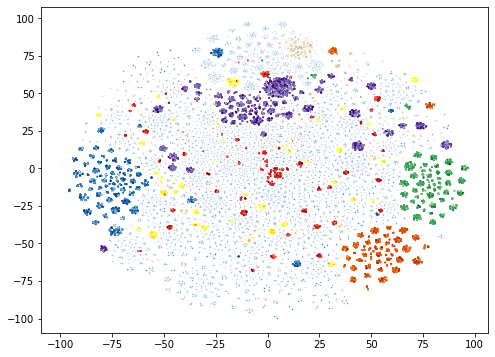

In [68]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)

plt.scatter(X_embedded_corrected[:, 0], X_embedded_corrected[:, 1], s = .1, alpha = 0.1)

num_concept = len(color_map_list)
selected_correct_q = [num_correct_q.index(np.sort(num_correct_q)[-i]) for i in range(num_concept)]
for i, color_map_name in zip(selected_correct_q, color_map_list):
    color_map = cm.get_cmap(color_map_name)
    color_idx = correct_diff_color_idx[correct_q_idxs == i]
    if i >= len(color_map_list) - 2:
        color_idx = np.flip(correct_diff_color_idx[correct_q_idxs == i])
    plt.scatter(X_embedded_corrected[correct_q_idxs == i][:, 0], X_embedded_corrected[correct_q_idxs == i][:, 1], color = color_map(color_idx), s = 1)

# plt.axis('off')
# plt.savefig('../model_records/concept_map_r=1.pdf')

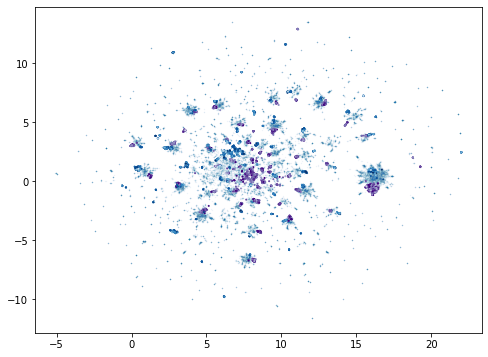

In [107]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)

plt.scatter(X_embedded_corrected_umap[:, 0], X_embedded_corrected_umap[:, 1], s = .1, alpha = 0.1)

num_concept = 3
selected_correct_q = [num_correct_q.index(np.sort(num_correct_q)[-i]) for i in range(num_concept)]
for i, color_map_name in zip(selected_correct_q, color_map_list):
    color_map = cm.get_cmap(color_map_name)
    color_idx = correct_diff_color_idx[correct_q_idxs == i]
    if i >= len(color_map_list) - 2:
        color_idx = np.flip(correct_diff_color_idx[correct_q_idxs == i])
    plt.scatter(X_embedded_corrected_umap[correct_q_idxs == i][:, 0], X_embedded_corrected_umap[correct_q_idxs == i][:, 1], color = color_map(color_idx), s = 1)

# plt.axis('off')
# plt.savefig('../model_records/concept_map_r=1.pdf')

In [100]:
diff_color_idx

array([0.77, 0.88, 0.91, ..., 0.41, 0.8 , 0.81])

In [102]:
diff_color_idx[q_idxs == i]

array([], dtype=float64)

In [105]:
q_idxs

array([32, 32, 32, ..., 20, 93, 93])

ValueError: 'c' argument has 54811 elements, which is inconsistent with 'x' and 'y' with size 0.

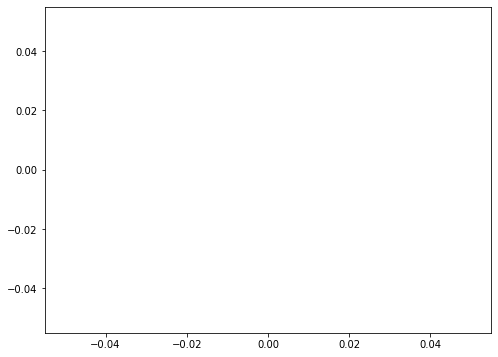

In [101]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)

plt.scatter(X_embedded_umap[q_idxs == i][:, 0], X_embedded_umap[q_idxs == i][:, 1], s = .01, alpha = 0.01)

num_concept = 4
selected_q = [num_q.index(np.sort(num_q)[-i]) for i in range(num_concept)]
for i, color_map_name in zip(selected_q, color_map_list):
    
    color_map = cm.get_cmap(color_map_name)
    color_idx = diff_color_idx[q_idxs == i]
    
    if i >= len(color_map_list) - 2:
        color_idx = np.flip(diff_color_idx)
        
    plt.scatter(X_embedded_umap[q_idxs == i][:, 0], X_embedded_umap[q_idxs == i][:, 1], color = color_map(color_idx), s = 1)

    
# plt.axis('off')
# plt.savefig('../model_records/concept_map_r=1.pdf')

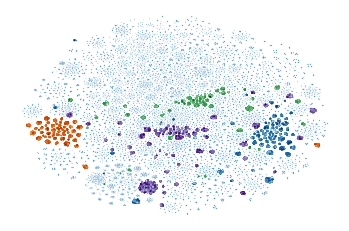

In [46]:
import matplotlib.pyplot as plt

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s = .1, alpha = 0.1)

num_concept = 5 # len(color_map_list)
selected_correct_q = [num_correct_q.index(np.sort(num_correct_q)[-i]) for i in range(num_concept)]
for i, color_map_name in zip(selected_correct_q, color_map_list):
    color_map = cm.get_cmap(color_map_name)
    color_idx = correct_diff_color_idx[correct_q_idxs == i]
    if i >= len(color_map_list) - 2:
        color_idx = np.flip(correct_diff_color_idx[correct_q_idxs == i])
    plt.scatter(X_embedded[r_color_idx == 1][correct_q_idxs == i][:, 0], X_embedded[r_color_idx == 1][correct_q_idxs == i][:, 1], color = color_map(color_idx), s = 1)

# plt.axis('off')
# plt.savefig('../model_records/concept_map_r=1.pdf')

In [31]:
color_map = cm.get_cmap('Reds')
color_idx = diff_color_idx

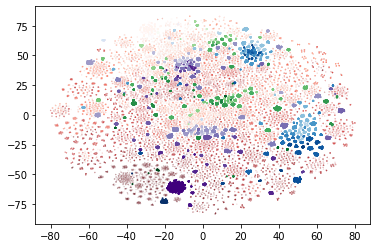

In [32]:
import matplotlib.pyplot as plt

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s = .1, c = color_map(color_idx), alpha = 0.1)

num_concept = 4
selected_q = [num_q.index(np.sort(num_q)[-i]) for i in range(num_concept)]
for i, color_map_name in zip(selected_q, color_map_list[:num_concept]):
    color_map = cm.get_cmap(color_map_name)
    color_idx = diff_color_idx[q_idxs == i]
    
    plt.scatter(X_embedded[q_idxs == i][:, 0], X_embedded[q_idxs == i][:, 1], color = color_map(color_idx), s = 1)
plt.savefig('concept_map.png')

In [49]:
min(diff_color_idx), max(diff_color_idx)

(0.0, 1.0)

In [53]:
import pickle
with open('../model_records/emb_diff.pickle', 'rb') as handle:
    emb_no_diff = pickle.load(handle)

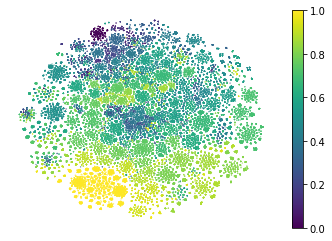

In [50]:
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = q_color_idx, s = .1)
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = r_color_idx, s = .1)
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = pid_color_idx, s = .1)

fig, axs = plt.subplots(1, 2)
axs[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c = diff_color_idx, s = .1)
axs[1].scatter(emb_no_diff['X'][:, 0], emb_no_diff['X'][:, 1], c = emb_no_diff['diff'], s = .1)

plt.colorbar()
plt.axis('off')
plt.savefig('../model_records/emb_diff_color_diff.pdf')

In [ ]:
ax1.set_ylabel("current exercise index", fontsize=16)

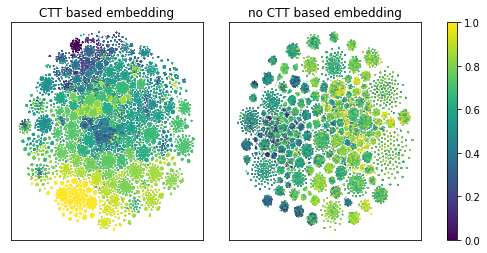

In [111]:
# figure
plt.rcParams["figure.figsize"] = (8, 4)

fig, (ax1, ax2, cax) = plt.subplots(ncols = 3, gridspec_kw={"width_ratios":[1, 1, 0.05]})
axs = [ax1, ax2]

# x_diff = axs[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c = r_color_idx, s = .1)
x_diff = axs[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c = diff_color_idx, s = .1)
axs[0].set_title('CTT based embedding', fontsize = 12)
x_no = axs[1].scatter(emb_no_diff['X'][:, 0], emb_no_diff['X'][:, 1], c = emb_no_diff['diff'], s = .1)
axs[1].set_title('no CTT based embedding', fontsize = 12)

fig.colorbar(x_diff, cax=cax)

axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].set_xticks([])
axs[1].set_yticks([])

# plt.show()
plt.savefig('../model_records/emb_diff_color_diff.pdf')

[]

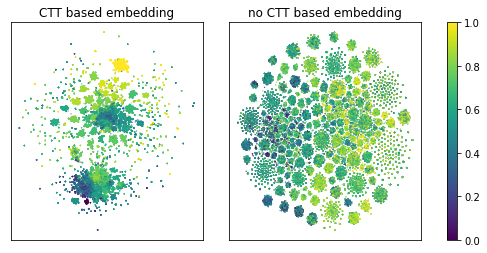

In [81]:
# figure
plt.rcParams["figure.figsize"] = (8, 4)

fig, (ax1, ax2, cax) = plt.subplots(ncols = 3, gridspec_kw={"width_ratios":[1, 1, 0.05]})
axs = [ax1, ax2]

x_diff = axs[0].scatter(X_embedded_umap[:, 0], X_embedded_umap[:, 1], c = diff_color_idx, s = .1)
axs[0].set_title('CTT based embedding', fontsize = 12)
x_no = axs[1].scatter(emb_no_diff['X'][:, 0], emb_no_diff['X'][:, 1], c = emb_no_diff['diff'], s = .1)
axs[1].set_title('no CTT based embedding', fontsize = 12)

fig.colorbar(x_diff, cax=cax)

axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].set_xticks([])
axs[1].set_yticks([])
plt.show()

# plt.savefig('../model_records/emb_diff_color_diff.pdf')

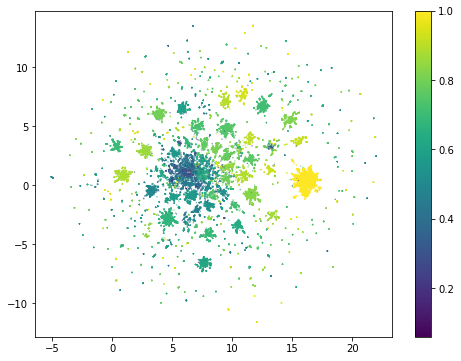

In [74]:
plt.rcParams["figure.figsize"] = (8, 6)
# plt.scatter(X_embedded_corrected_umap[:, 0], X_embedded_corrected_umap[:, 1], c = correct_q_color_idx, s = .1)
# plt.scatter(X_embedded_corrected_umap[:, 0], X_embedded_corrected_umap[:, 1], c = correct_r_color_idx, s = .1)
# plt.scatter(X_embedded_corrected_umap[:, 0], X_embedded_corrected_umap[:, 1], c = correct_pid_color_idx, s = .1)
plt.scatter(X_embedded_corrected_umap[:, 0], X_embedded_corrected_umap[:, 1], c = correct_diff_color_idx, s = .1)
plt.colorbar()
plt.show()
# plt.savefig('emb_diff_r=1.png')

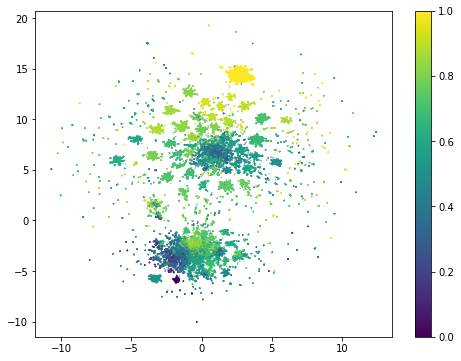

In [79]:
plt.rcParams["figure.figsize"] = (8, 6)
# plt.scatter(X_embedded_umap[:, 0], X_embedded_umap[:, 1], c = correct_q_color_idx, s = .1)
# plt.scatter(X_embedded_umap[:, 0], X_embedded_umap[:, 1], c = r_color_idx, s = .1)
# plt.scatter(X_embedded_umap[:, 0], X_embedded_umap[:, 1], c = correct_pid_color_idx, s = .1)
plt.scatter(X_embedded_umap[:, 0], X_embedded_umap[:, 1], c = diff_color_idx, s = .1)
plt.colorbar()
plt.show()
# plt.savefig('emb_diff_r=1.png')

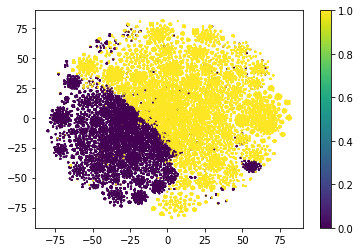

In [67]:
import matplotlib.pyplot as plt

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = color_idx, s = 1)
plt.colorbar()
plt.savefig('emb_r.png')

In [62]:
import umap

In [63]:
embedding = umap.UMAP().fit_transform(emb_vec)

AttributeError: module 'umap' has no attribute 'UMAP'

In [93]:
%%time
# umap
import umap
reload(umap)
reducer = umap.UMAP()
embedding = reducer.fit_transform(emb_vec)
embedding.shape

AttributeError: module 'umap' has no attribute 'UMAP'

In [ ]:
import matplotlib.cm as cm
color_map = cm.get_cmap('Reds')
color_idx = diff_idxs

plt.plot(beta_space[phase_idx], kl_traj[i][phase_idx], linewidth = 1, color = color_map(color_idx))

In [ ]:
plt.scatter(X_embedded)
plt.show()

In [27]:
trainer.model.eval()
q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data

device(type='cuda', index=0)

In [28]:
q_seqs = q_seqs.to(trainer.device)
r_seqs = r_seqs.to(trainer.device)
pid_seqs = pid_seqs.to(trainer.device)
diff_seqs = diff_seqs.to(trainer.device)
mask_seqs = mask_seqs.to(trainer.device)

real_seqs = r_seqs.clone()

mlm_r_seqs, mlm_idxs = Mlm4BertTest(r_seqs, mask_seqs)

mlm_r_seqs = mlm_r_seqs.to(trainer.device)
mlm_idxs = mlm_idxs.to(trainer.device)

In [31]:
emb = trainer.model.emb_q(q_seqs.type(torch.long)) + \
    trainer.model.emb_r(r_seqs.type(torch.long)) + \
    trainer.model.emb_pid(pid_seqs.type(torch.long)) + \
    trainer.model.emb_diff(diff_seqs.type(torch.long)) + \
    trainer.model._positional_embedding(q_seqs.type(torch.long))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper__index_select)

In [24]:
emb = trainer._get_emb(q_seqs, r_seqs, pid_seqs, diff_seqs)
trainer._save_emb(data, emb)

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [ ]:
self.filter_dict_q    = {f'{q_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for q_idx in range(model.num_q)}
self.filter_dict_pid  = {f'{emb_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for emb_idx in range(model.num_pid)}
self.filter_dict_diff = {f'{diff_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for diff_idx in range(model.num_diff)}

self.conv_value_dict_q    = {f'{q_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for q_idx in range(model.num_q)}
self.conv_value_dict_pid  = {f'{emb_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for emb_idx in range(model.num_pid)}
self.conv_value_dict_diff = {f'{diff_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for diff_idx in range(model.num_diff)}

In [212]:
trainer.attn_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

In [215]:
def vis_attn(
    save_plot = False
):
    fig, axs = plt.subplots(num_encoder, num_head)
    for encoder_idx in range(num_encoder):
        for head_idx in range(num_head):
            attn_map = torch.mean(torch.stack(trainer.attn_dict[head_idx][encoder_idx], dim = 0), dim = 0)
            axs[encoder_idx, head_idx].imshow(attn_map.cpu().numpy(), interpolation='antialiased', aspect='auto')                
    # fig.suptitle(f'main-{main_idxs}_layer_idx-{layer_idxs}_head_idx-{head_idxs}')
    if save_plot:
        plt.savefig(f'attn_map.png')
    else:
        plt.show()

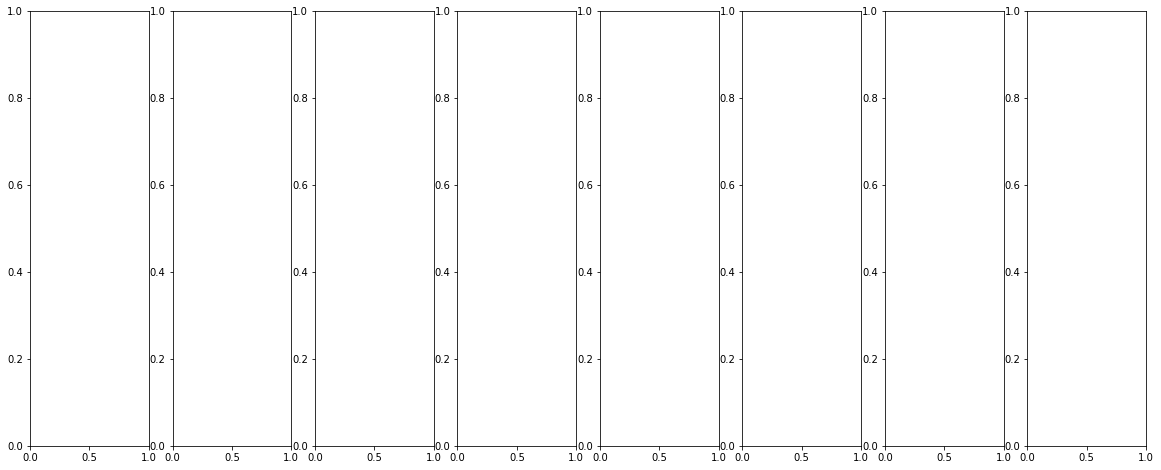

In [228]:
num_encoder = 1
num_head = 8
plt.rcParams["figure.figsize"] = (20,8)
fig, axs = plt.subplots(num_encoder, num_head)

In [234]:
def vis_attn(
    layer_avg = False,
    head_avg  = False,
    save_plot = False,
):
    num_encoder = 1 if layer_avg else 12
    num_head = 1 if head_avg else 8
    
    fig, axs = plt.subplots(num_encoder, num_head)
    for encoder_idx in range(num_encoder):
        for head_idx in range(num_head):
            
            attn_map = torch.zeros(100, 100, device = 'cuda:0')
            if layer_avg:
                for enc in range(8):
                    attn_map += torch.mean(torch.stack(trainer.attn_dict[head_idx][enc], dim = 0), dim = 0)
            elif head_avg:
                for head in range(12):
                    attn_map += torch.mean(torch.stack(trainer.attn_dict[head][encoder_idx], dim = 0), dim = 0)
            else:
                attn_map += torch.mean(torch.stack(trainer.attn_dict[head_idx][encoder_idx], dim = 0), dim = 0)
                
            if layer_avg:
                axs[head_idx].imshow(attn_map.cpu().numpy(), interpolation='antialiased', aspect='auto')                
            elif head_avg:
                axs[encoder_idx].imshow(attn_map.cpu().numpy(), interpolation='antialiased', aspect='auto')                
            else:
                axs[encoder_idx, head_idx].imshow(attn_map.cpu().numpy(), interpolation='antialiased', aspect='auto')                
            
    fig.suptitle(f'attn_map')
    if save_plot:
        plt.savefig(f'attn_map : layer_avg-{layer_avg} head_avg-{head_avg}.png')
    else:
        plt.show()

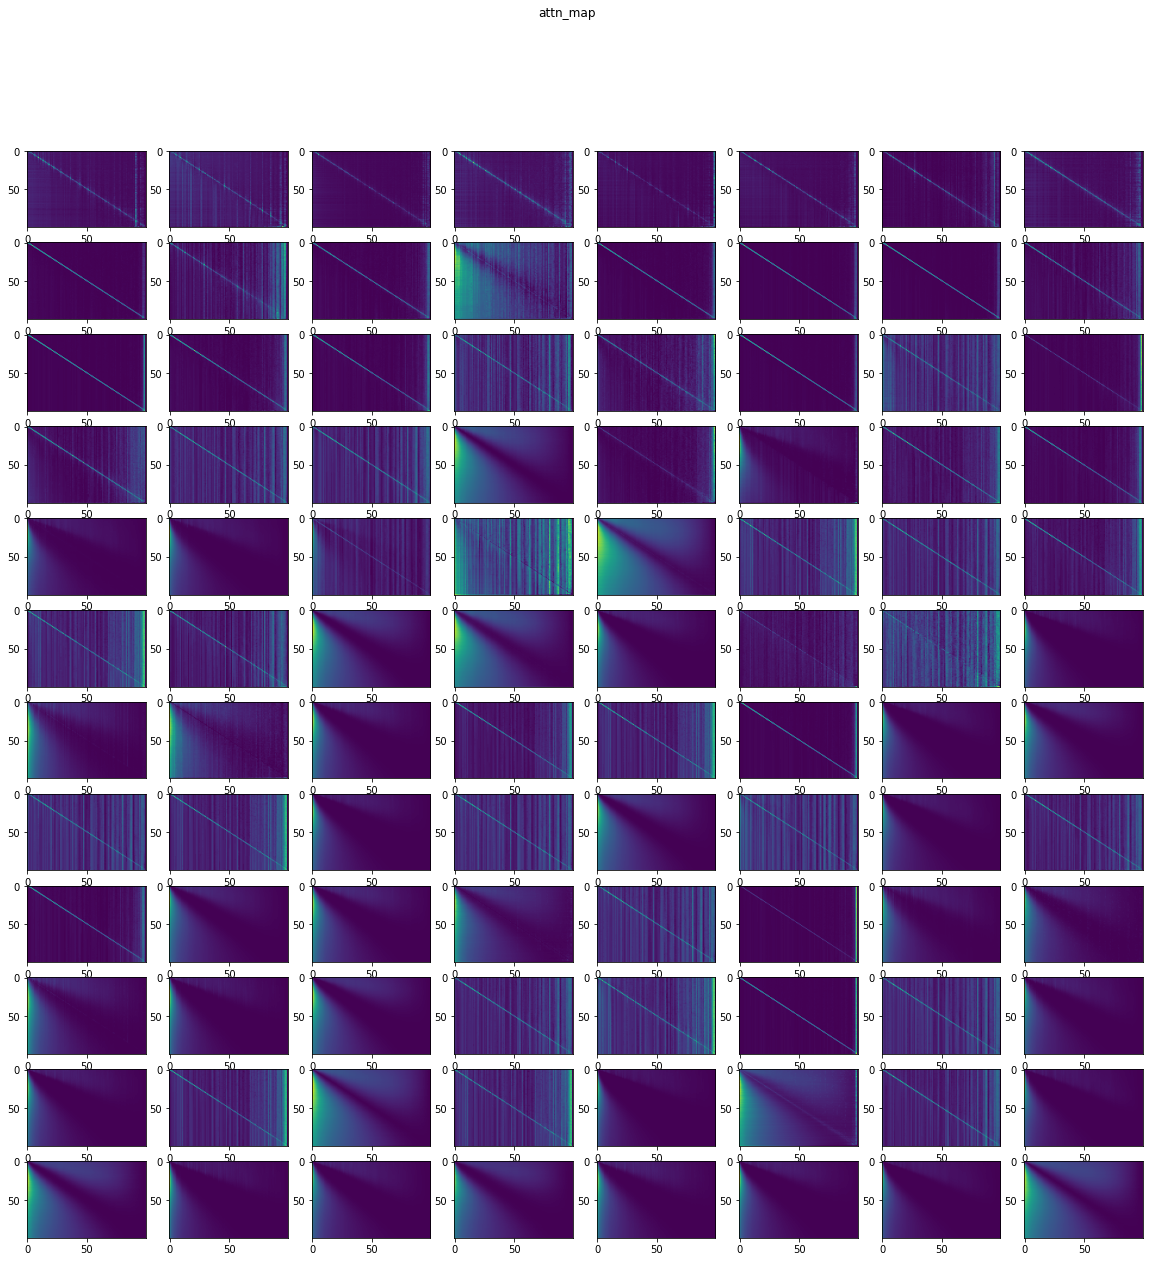

In [236]:
plt.rcParams["figure.figsize"] = (20,20)
vis_attn(
    layer_avg = False,
    head_avg  = False,
    save_plot = True,
)

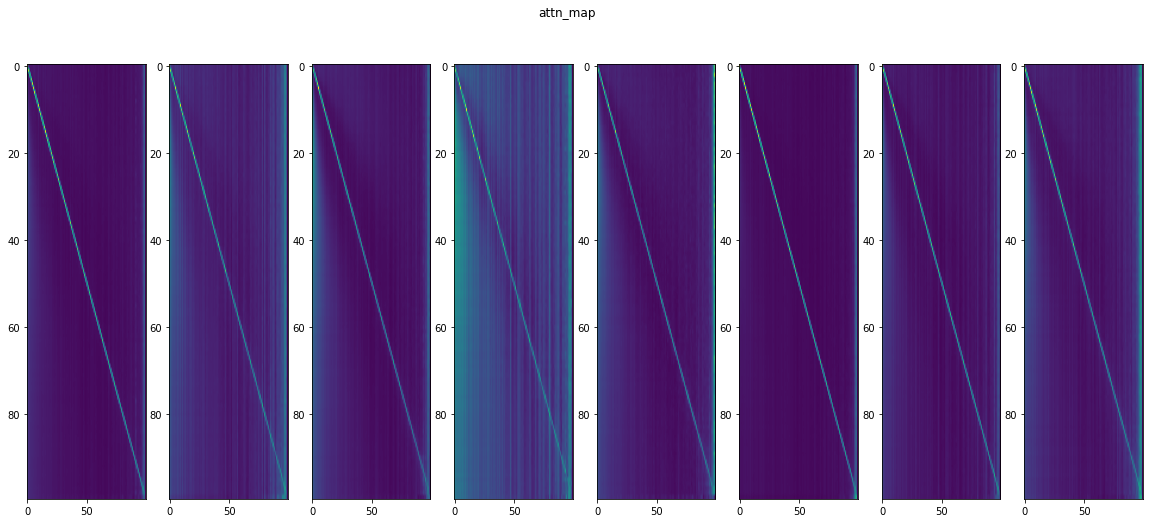

In [233]:
vis_attn(
    layer_avg = True,
    head_avg  = False,
    save_plot = False,
)

In [193]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,20)
def vis_filter(
    main = 'q',
    main_idxs = [0, 25, 50, 75, 100], 
    head_idxs = np.arange(0, num_head).tolist(), 
    layer_idxs = [0], 
    x_axis = 'main', 
    y_axis = 'head',
    save_plot = False,
):
    # check main column
    assert main in ['q', 'pid', 'diff']
    
    # 
    main_filter = getattr(trainer, f'filter_dict_{main}')
    
    # 
    valid_filter_list = list(filter(lambda x: main_filter[x][0] != [], main_filter.keys()))
    main_idxs = list(filter(lambda x: x in valid_filter_list, main_idxs))
    
    get_idxs = {
        f'{main}' : main_idxs,
        'head'  : head_idxs,
        'layer' : layer_idxs,
    }
    
    x_axis = main if x_axis is 'main' else x_axis
    y_axis = main if y_axis is 'main' else y_axis
    
    fig, axs = plt.subplots(len(get_idxs[x_axis]), len(get_idxs[y_axis]))

    for main_plot_idx, main_idx in enumerate(main_idxs):
        for layer_plot_idxs, layer_idx in enumerate(layer_idxs):
            for head_plot_idxs, head_idx in enumerate(head_idxs):
                # get example filters per main
                filters = main_filter[main_idx]
                
                try:
                    filters[0][0].shape
                except:
                    pass

                # get example filters per layer, head
                filter_0_0 = torch.stack([filter_[head_idx] for filter_ in filters[layer_idx]], dim = 0)

                # plot
                plot_idxs = {
                    f'{main}'  : main_plot_idx,
                    'head'  : head_plot_idxs,
                    'layer' : layer_plot_idxs,
                }

                x_idx = plot_idxs[x_axis]
                y_idx = plot_idxs[y_axis]

                axs[x_idx, y_idx].imshow(filter_0_0.cpu().numpy(), interpolation='antialiased', aspect='auto')
                
    fig.suptitle(f'main-{main_idxs}_layer_idx-{layer_idxs}_head_idx-{head_idxs}')
    if save_plot:
        plt.savefig(f'main-{main_idxs}_layer_idx-{layer_idxs}_head_idx-{head_idxs}.png')
    else:
        plt.show()

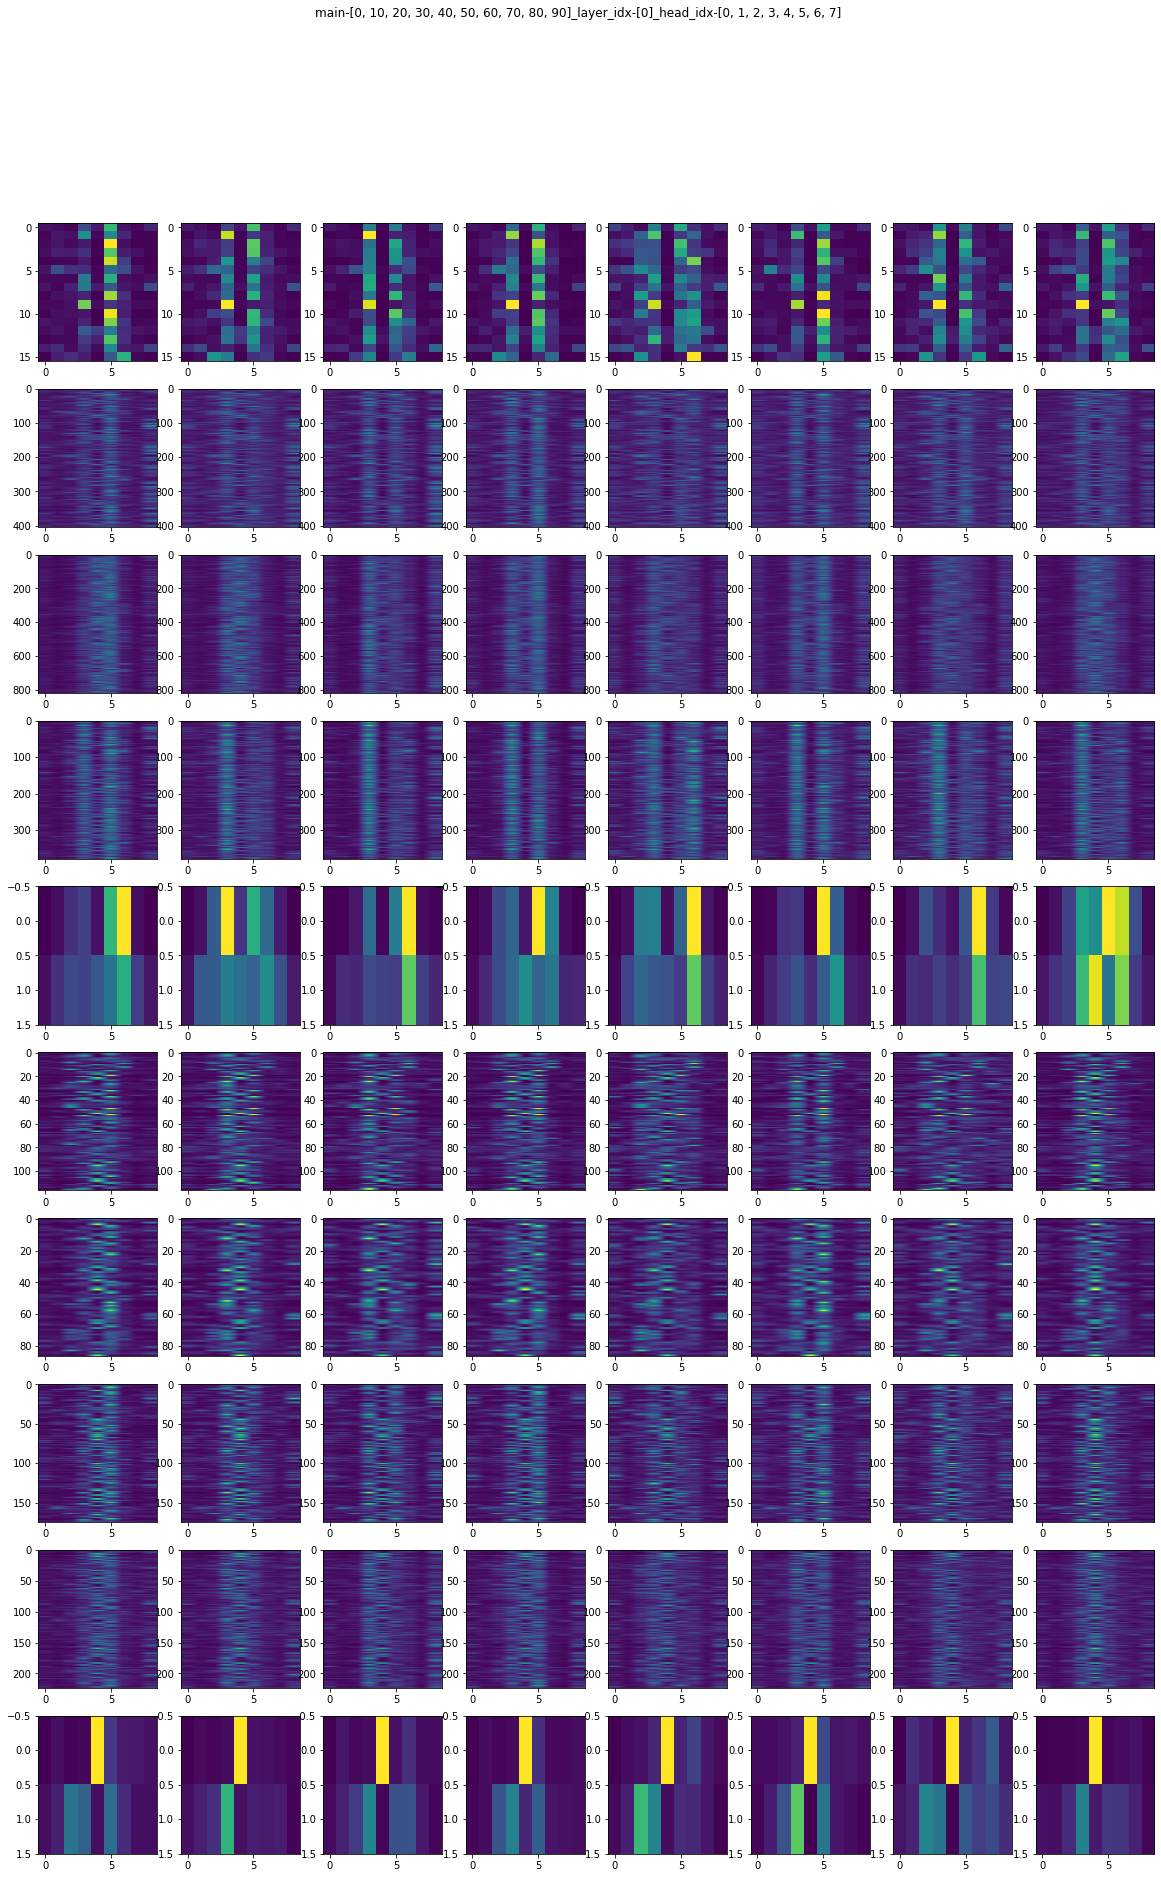

In [197]:
vis_filter(
    main = 'q',
    main_idxs = np.arange(0, 100, step = 10).tolist(), 
    head_idxs = np.arange(0, num_head).tolist(), 
    layer_idxs = [0], 
    x_axis = 'main', 
    y_axis = 'head',
    save_plot = False,
)

In [106]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,30)
def vis_filter_diff(
    diff_idxs = [0, 25, 50, 75, 100], 
    head_idxs = np.arange(0, num_head).tolist(), 
    layer_idxs = [0], 
    x_axis = 'diff', 
    y_axis = 'head',
    save_plot = False,
):
    fig, axs = plt.subplots(len(get_idxs[x_axis]), len(get_idxs[y_axis]))

    for diff_plot_idx, diff_idx in enumerate(diff_idxs):
        for layer_plot_idxs, layer_idx in enumerate(layer_idxs):
            for head_plot_idxs, head_idx in enumerate(head_idxs):
                # get example filters per diff
                filters = trainer.filter_dict_diff[diff_idx]

                # get example filters per layer, head
                filter_0_0 = torch.stack([filter_[head_idx] for filter_ in filters[layer_idx]], dim = 0)

                # plot
                plot_idxs = {
                    'diff'  : diff_plot_idx,
                    'head'  : head_plot_idxs,
                    'layer' : layer_plot_idxs,
                }

                x_idx = plot_idxs[x_axis]
                y_idx = plot_idxs[y_axis]

                axs[x_idx, y_idx].imshow(filter_0_0.cpu().numpy(), interpolation='antialiased', aspect='auto')
                
    if save_plot:
        plt.savefig(f'diff-{diff_idx}_layer_idx-{layer_idx}_head_idx-{head_idx}.png')
    else:
        plt.show()

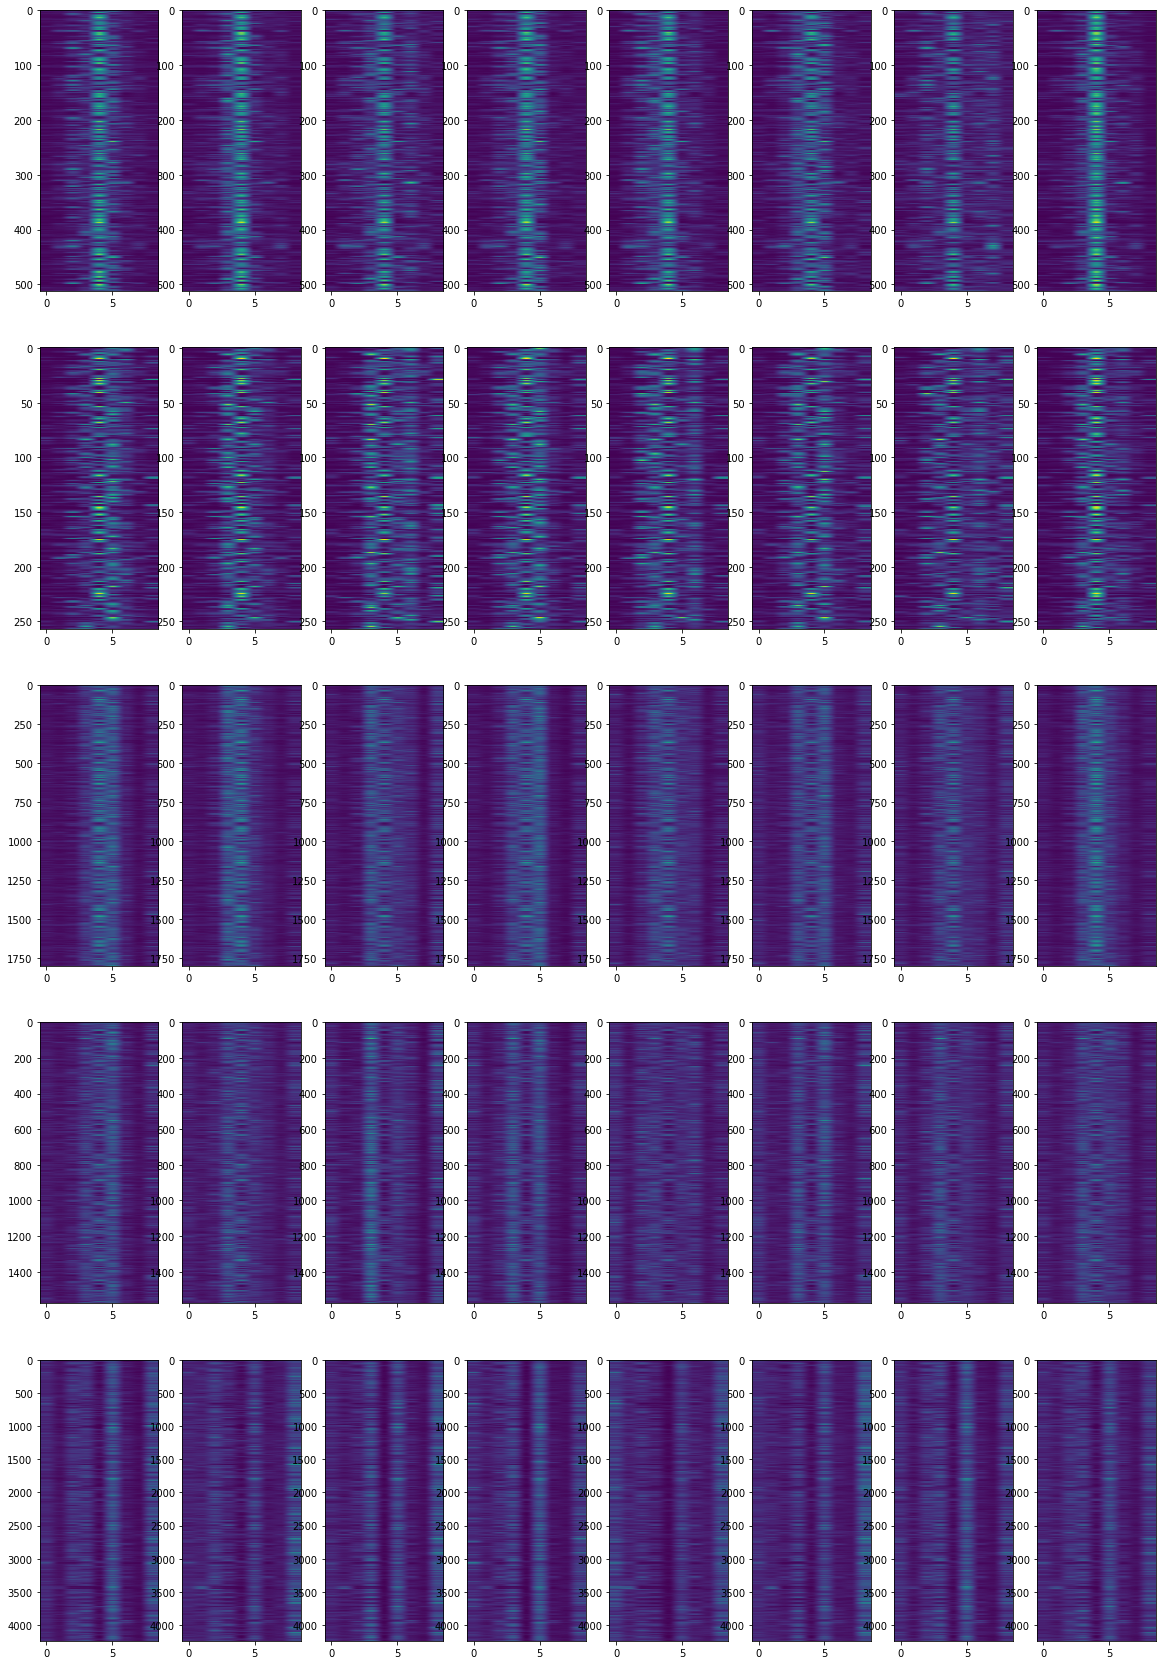

In [107]:
vis_filter_diff()

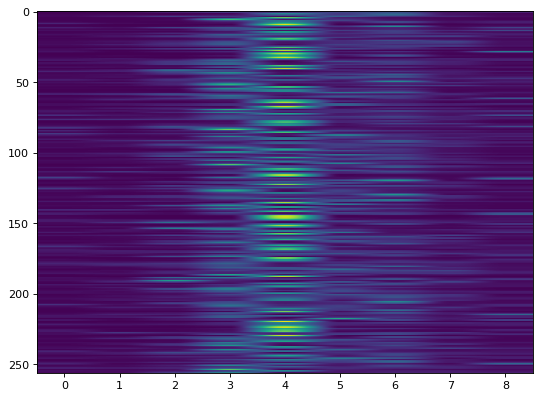

In [78]:
# get example filters per diff
diff_idx = 25
filters = trainer.filter_dict_diff[diff_idx]

# get example filters per layer, head
layer_idx = 0
head_idx = 7
filter_0_0 = torch.stack([filter_[head_idx] for filter_ in filters[layer_idx]], dim = 0)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(filter_0_0.cpu().numpy(), interpolation='antialiased', aspect='auto')
plt.savefig(f'diff-{diff_idx}_layer_idx-{layer_idx}_head_idx-{head_idx}.png')

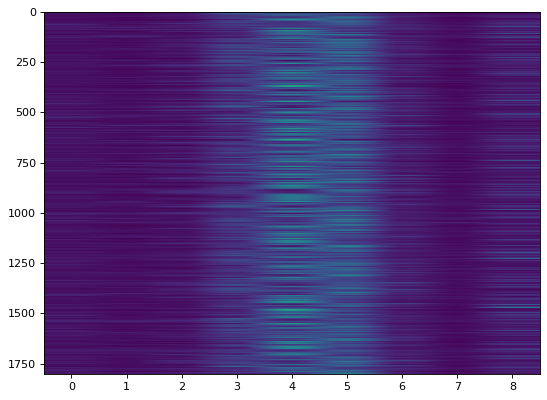

In [65]:
# get example filters per diff
diff_idx = 50
filters = trainer.filter_dict_diff[diff_idx]

# get example filters per layer, head
layer_idx = 0
head_idx = 0
filter_0_0 = torch.stack([filter_[head_idx] for filter_ in filters[layer_idx]], dim = 0)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(filter_0_0.cpu().numpy(), interpolation='antialiased', aspect='auto')
plt.savefig(f'diff-{diff_idx}_layer_idx-{layer_idx}_head_idx-{head_idx}.png')

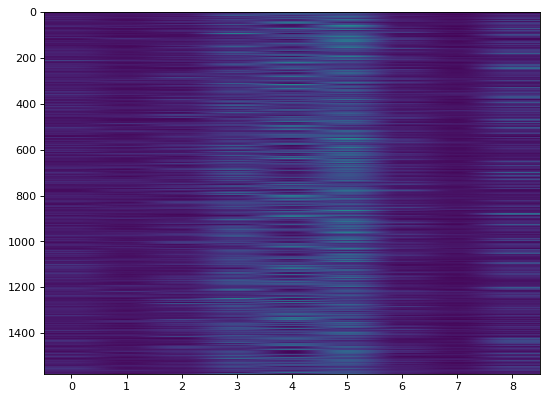

In [63]:
# get example filters per diff
diff_idx = 75
filters = trainer.filter_dict_diff[diff_idx]

# get example filters per layer, head
layer_idx = 0
head_idx = 0
filter_0_0 = torch.stack([filter_[head_idx] for filter_ in filters[layer_idx]], dim = 0)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(filter_0_0.cpu().numpy(), interpolation='antialiased', aspect='auto')
plt.savefig(f'diff-{diff_idx}_layer_idx-{layer_idx}_head_idx-{head_idx}.png')

In [25]:
# for 
[ filters[0][0][0] for ]
filters[0][0][0] # sample_idx, head_idx, kernel_size

tensor([0.0161, 0.0119, 0.0052, 0.0113, 0.8743, 0.0203, 0.0269, 0.0208, 0.0133],
       device='cuda:0')

In [14]:
for k, v in trainer.filter_dict_diff.items():
    print(len(v[0]))

513
0
0
0
17
6
26
25
44
31
42
48
65
36
102
73
50
163
106
64
185
38
125
63
118
257
112
154
116
260
251
194
181
626
170
219
325
225
522
214
439
467
546
584
500
466
454
634
569
330
1803
508
572
744
657
891
1017
1271
1041
675
1209
789
1338
557
945
1006
582
2035
762
1122
963
1374
758
1019
782
1579
1074
789
982
877
1226
835
921
1314
549
779
1068
508
1080
870
611
504
453
382
484
249
120
133
36
0
4237


In [97]:
model.encoder[0].attn.filters.shape

torch.Size([45600, 9, 1])

In [62]:
from einops import rearrange

In [105]:
for data in test_loader:
    break

In [179]:
%%time


CPU times: user 6.57 ms, sys: 883 µs, total: 7.46 ms
Wall time: 5.92 ms


In [177]:
q

'92'

In [178]:
filter_layers.shape

torch.Size([57, 100, 12, 8, 9])

IndexError: index 57 is out of bounds for dimension 0 with size 57

In [130]:
attn = model.encoder[encoder_idx].attn

In [132]:
rearrange(attn.filters, '(bs n h) k 1 -> bs n h k', n = max_seq_len, h = 8).shape

torch.Size([57, 100, 8, 9])

In [140]:
rearrange(attn.conv_value_vectors, 'bs (h_idx h_size) n 1 -> bs h_idx h_size n', h_idx = 8).shape

torch.Size([57, 8, 32, 100])

In [131]:
attn.conv_value_vectors.shape

torch.Size([57, 256, 100, 1])

In [ ]:
model.encoder[0].attn.attn_scores

In [ ]:
        filter_dict_q[]
        filter_dict_pid
        filter_dict_diff
        conv_value_dict_q
        conv_value_dict_pid
        conv_value_dict_diff

In [103]:
for encoder_idx, encoder in enumerate(model.encoder):
    

In [ ]:
filter_dict_q    = {f'{q_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for q_idx in range(model.num_q)}
filter_dict_pid  = {f'{emb_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for emb_idx in range(model.num_pid)}
filter_dict_diff = {f'{diff_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for diff_idx in range(model.num_diff)}

conv_value_dict_q    = {f'{q_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for q_idx in range(model.num_q)}
conv_value_dict_pid  = {f'{emb_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for emb_idx in range(model.num_pid)}
conv_value_dict_diff = {f'{diff_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for diff_idx in range(model.num_diff)}

In [104]:
encoder.attn.attn_scores.shape

torch.Size([57, 8, 100, 100])

In [98]:
model.encoder[0].attn.attn_scores.shape

torch.Size([57, 8, 100, 100])

In [102]:
model.encoder[0].attn.conv_value_vectors.squeeze().permute(0, 2, 1).shape

torch.Size([57, 100, 256])

In [100]:
filters = rearrange(model.encoder[0].attn.filters, '(bs n h) k 1 -> bs n h k', n = max_seq_len, h = 8).shape

torch.Size([57, 100, 8, 9])

In [43]:
rearrange(model.encoder[0].attn.filters, '(bs n h) k 1 -> bs n h k', n = max_seq_len, h = 8).shape

torch.Size([57, 100, 8, 9])

In [ ]:
model.encoder[0].attn.filters.shape

In [34]:
attn_outputs = attn_outputs.detach().cpu().numpy()
attn_probs = attn_probs.detach().cpu().numpy()
emb = emb.detach().cpu().numpy()
emb_q = emb_q.detach().cpu().numpy()
emb_pid = emb_pid.detach().cpu().numpy()
emb_diff = emb_diff.detach().cpu().numpy()

In [35]:
print("attn_outputs[0].size()", attn_outputs[0].size())
print("attn_probs[0][0].size()", attn_probs[0][0].size())
print("emb", emb.size())
print("emb_q", emb_q.size())
print("emb_pid", emb_pid.size())
print("emb_diff ", emb_diff.size())

TypeError: 'int' object is not callable

In [36]:
import pickle

attn_path = "../visual_records/attn_data.pkl"
outputs_path = "../visual_records/outputs.pkl"
emb_path = "../visual_records/emb.pkl"
emb_q_path = "../visual_records/emb_q.pkl"
emb_pid_path = "../visual_records/emb_pid.pkl"
emb_diff_path = "../visual_records/emb_diff.pkl"

# pickfile save
with open(attn_path, "wb") as f:
    pickle.dump(attn_probs, f)
with open(outputs_path, "wb") as f:
    pickle.dump(attn_outputs, f)
with open(emb_path, "wb") as f:
    pickle.dump(emb, f)
with open(emb_q_path, "wb") as f:
    pickle.dump(emb_q, f)
with open(emb_pid_path, "wb") as f:
    pickle.dump(emb_pid, f)
with open(emb_diff_path, "wb") as f:
    pickle.dump(emb_diff, f)

In [37]:
import pickle

attn_path = "../visual_records/attn_data.pkl"
outputs_path = "../visual_records/outputs.pkl"
emb_path = "../visual_records/emb.pkl"
emb_q_path = "../visual_records/emb_q.pkl"
emb_pid_path = "../visual_records/emb_pid.pkl"
emb_diff_path = "../visual_records/emb_diff.pkl"

# pickfile load
with open(attn_path, "rb") as f:
    attn_probs2 = pickle.load(f)
with open(outputs_path, "rb") as f:
    attn_outputs2 = pickle.load(f)
with open(emb_path, "rb") as f:
    emb2 = pickle.load(f)
with open(emb_q_path, "rb") as f:
    emb_q2 = pickle.load(f)
with open(emb_pid_path, "rb") as f:
    emb_pid2 = pickle.load(f)
with open(emb_diff_path, "rb") as f:
    emb_diff2 = pickle.load(f)

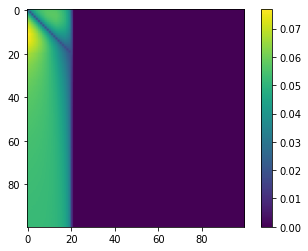

In [38]:
# 시각화

import matplotlib.pyplot as plt

score = attn_probs[0][0]

plt.viridis()
plt.imshow(score)
plt.colorbar()

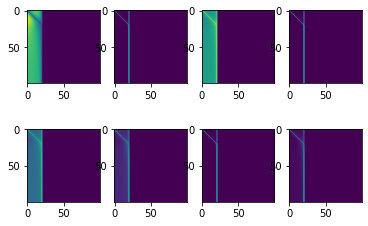

<Figure size 1440x576 with 0 Axes>

In [40]:
for i in range(8):
    score = attn_probs[0][i]
    plt.subplot(2,4,i+1)
    plt.viridis()
    plt.imshow(score)
    

plt.figure(figsize=(20, 8))
plt.show()


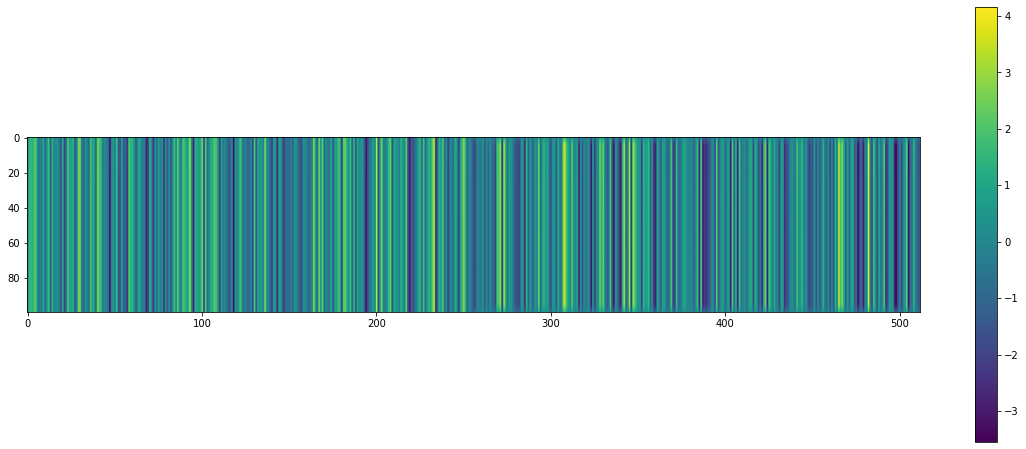

In [41]:
# 시각화

import matplotlib.pyplot as plt

outputs_score = attn_outputs[0]

plt.figure(figsize=(20, 8))
plt.viridis()
plt.imshow(outputs_score)
plt.colorbar()

In [42]:
#attn_probs2
#attn_outputs2
#emb2
#emb_q2
#emb_pid2
#emb_diff2

# t-sne
from sklearn.manifold import TSNE

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
tsne_model = TSNE(n_components=n_components)

tsne_result = tsne_model.fit_transform(emb2)

print(tsne_result)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: Found array with dim 3. Estimator expected <= 2.

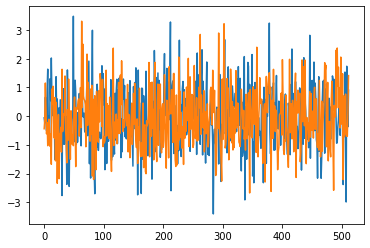

In [270]:
import matplotlib.pyplot as plt
# plt.imshow(model.emb_q.weight.detach().cpu().numpy()), print(model.emb_q.weight.detach().cpu().numpy().var())
plt.plot(model.emb_r.weight.t().detach().cpu().numpy()[:, 0])
plt.plot(model.emb_r.weight.t().detach().cpu().numpy()[:, 1])
# plt.imshow(model.emb_pid.weight.t().detach().cpu().numpy()[:, :1000]), print(model.emb_pid.weight.t().detach().cpu().numpy().var())
# plt.imshow(model.emb_diff.weight.detach().cpu().numpy()), print(model.emb_diff.weight.detach().cpu().numpy().var())
# plt.imshow(model.emb_p.weight.detach().cpu().numpy()), print(model.emb_p.weight.detach().cpu().numpy().var())
plt.show()

In [6]:
from torch.optim import Adam
from torch.nn.functional import binary_cross_entropy

optimizer = Adam(model.parameters(), learning_rate)
crit = binary_cross_entropy

In [6]:
from torch.optim import Adam
from torch.nn.functional import binary_cross_entropy

optimizer = Adam(model.parameters(), learning_rate)
crit = binary_cross_entropy

In [18]:
for idx, data in enumerate(tqdm(train_loader)):
    model.train()
    q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data

    q_seqs = q_seqs.to(model.device) # |q_seqs| = (bs, n)
    r_seqs = r_seqs.to(model.device) # |r_seqs| = (bs, n)
    pid_seqs = pid_seqs.to(model.device) # |pid_seqs| = (bs, n)
    diff_seqs = diff_seqs.to(model.device)
    mask_seqs = mask_seqs.to(model.device) # |mask_seqs| = (bs, n)

    # for correct
    real_seqs = r_seqs.clone()

    # mlm_r_seqs: for MLM, [MASK] position get 2 / mlm_idx are index of [MASK]
    mlm_r_seqs, mlm_idxs = Mlm4BertTrain(r_seqs, mask_seqs)
    mlm_r_seqs = mlm_r_seqs.to(model.device)
    mlm_idxs = mlm_idxs.to(model.device)
    break    

  0%|          | 0/61 [00:00<?, ?it/s]


In [64]:
# model input
q = q_seqs.long()
r = r_seqs.long()
pid = pid_seqs.long()
diff = diff_seqs.long()
mask = mask_seqs.long()

In [65]:
model.eval()

# generate encoder input
emb = model.emb_q(q) + model.emb_r(r) + model.emb_pid(pid) + model.emb_diff(diff) + model._positional_embedding(q)
# |emb| = (bs, n, emb_size)

z = model.emb_dropout(emb)
# |z| = (bs, n, emb_size)

# |mask_enc| = (bs, n, n)
# |z| = (bs, n, emb_size)
attn_probs = None
attn_outputs = None

In [66]:
x = z
for enc_idx, block in enumerate(model.encoder):
    break

In [67]:
# z = x + model.encoder[enc_idx].attn_dropout(
#     model.encoder[enc_idx].attn(Q=z, K=z, V=z, mask=mask)
# )

z = model.encoder[enc_idx].attn_norm(x)

# encoder input
Q=z 
K=z
V=z
mask=mask

In [ ]:
# z = z + model.encoder[enc_idx].fc_dropout(model.encoder[enc_idx].fc(model.encoder[enc_idx].fc_norm(z)))

In [76]:
## MHSA qkv
batch_size = Q.size(0)

mixed_query_layer = model.encoder[enc_idx].attn.query(Q)
mixed_key_layer = model.encoder[enc_idx].attn.key(K)
mixed_value_layer = model.encoder[enc_idx].attn.value(V)

query_layer = model.encoder[enc_idx].attn.transpose_for_scores(mixed_query_layer)
# |query_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)
key_layer = model.encoder[enc_idx].attn.transpose_for_scores(mixed_key_layer)
# |query_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)
value_layer = model.encoder[enc_idx].attn.transpose_for_scores(mixed_value_layer)
# |query_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)

In [77]:
## conv qkv
mixed_key_conv_attn_layer = model.encoder[enc_idx].attn.key_conv_attn_layer(
    K.transpose(1, 2) # |hidden_states.transpose(1, 2)| = (bs, hs, n)
)
# |mixed_key_conv_attn_layer| = (bs, hs/2(all_attn_h_size), n)
mixed_key_conv_attn_layer = mixed_key_conv_attn_layer.transpose(1, 2)
# |mixed_key_conv_attn_layer| = (bs, n, hs/2(all_attn_h_size))

In [210]:
##############
# conv layer #
##############
# element-wise multiply of conv key and query 
conv_attn_layer = torch.multiply(mixed_key_conv_attn_layer, mixed_query_layer)

In [216]:
# |conv_attn_layer| = (bs, n, hs/2(all_attn_h_size))
conv_kernel_layer = model.encoder[enc_idx].attn.conv_kernel_layer(conv_attn_layer)

In [217]:
conv_kernel_layer.shape

torch.Size([64, 100, 72])

In [212]:
# |conv_kernel_layer| = (bs, n, (n_attn_h * conv_kernel_size) = (64, 100, 8 * 9) = (64, 100, 72)
conv_kernel_layer = torch.reshape(conv_kernel_layer, [-1, model.encoder[enc_idx].attn.conv_kernel_size, 1])

In [213]:
# |conv_kernel_layer| = (51200, 9, 1)
conv_kernel_layer = torch.softmax(conv_kernel_layer, dim=1)
# |conv_kernel_layer| = (51200, 9, 1)

In [218]:
# q X k is matmul with v
conv_out_layer = model.encoder[enc_idx].attn.conv_out_layer(V)

In [219]:
conv_out_layer.shape

torch.Size([64, 100, 256])

In [196]:
# |conv_out_layer| = (bs, n, hs/2(all_attn_h_size))
conv_out_layer = torch.reshape(conv_out_layer, [batch_size, -1, model.encoder[enc_idx].attn.all_head_size])

In [197]:
# |conv_out_layer| = (bs, n, hs/2(all_attn_h_size))
conv_out_layer = conv_out_layer.transpose(1, 2).contiguous().unsqueeze(-1)
# |conv_out_layer| = (bs, hs/2(all_attn_h_size), n, 1)

In [198]:
# unfold 참고 -> #https://www.facebook.com/groups/PyTorchKR/posts/1685133764959631/
conv_out_layer = nn.functional.unfold( 
    conv_out_layer,
    kernel_size=[model.encoder[enc_idx].attn.conv_kernel_size, 1],
    dilation=1,
    padding=[(model.encoder[enc_idx].attn.conv_kernel_size - 1) // 2, 0],
    stride=1,
)

In [199]:
# |conv_out_layer| = (64, 2304, 100)
conv_out_layer = conv_out_layer.transpose(1, 2).reshape(
    batch_size, -1, model.encoder[enc_idx].attn.all_head_size, model.encoder[enc_idx].attn.conv_kernel_size
)

In [200]:
# |conv_out_layer| = (bs, n, hs/2(all_attn_h_size), conv_kernal_size)
conv_out_layer = torch.reshape(conv_out_layer, [-1, model.encoder[enc_idx].attn.attention_head_size, model.encoder[enc_idx].attn.conv_kernel_size])
# |conv_out_layer|, default = (51200, 32, 9)

In [201]:
conv_out_layer.shape

torch.Size([51200, 32, 9])

In [202]:
conv_kernel_layer.shape

torch.Size([51200, 9, 1])

In [203]:
# matmul(q X k, v)
conv_out_layer = torch.matmul(conv_out_layer, conv_kernel_layer)
# |conv_out_layer|, default = (51200, 32, 1)

In [206]:
from einops import rearrange

In [208]:
conv_out_layer_einsum = torch.einsum('s h k, s k i -> s h i', conv_out_layer, conv_kernel_layer)

In [209]:
conv_out_layer_einsum.shape

torch.Size([51200, 32, 1])

In [ ]:
conv_out_layer = torch.reshape(conv_out_layer, [-1, model.encoder[enc_idx].attn.all_head_size])
# |conv_out_layer|, default = (6400, 256)

In [72]:
###################
# self_attn layer #
###################
attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
# |attention_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)
attention_scores = attention_scores / math.sqrt(model.encoder[enc_idx].attn.attention_head_size)
# |attention_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)

#####################
# distance function #
#####################
dist_scores = model.encoder[enc_idx].attn.dist_func(attention_scores, mask)
# |dist_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)
m = nn.Softplus()
# gamma is learnable decay rate parameter
gamma = -1.0 * m(model.encoder[enc_idx].attn.gammas).unsqueeze(0)
# Now after do exp(gamma * distance) and then clamp to 1e-5 to 1e-5
total_effect = torch.clamp(
    torch.clamp((dist_scores * gamma).exp(), min=1e-5), max=1e5
)
# |total_effect| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)

attention_scores = attention_scores * total_effect
# |attention_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)

# |mask| = (bs, n)
attention_mask = model.encoder[enc_idx].attn.get_extended_attention_mask(mask)
# |attention_mask| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)
attention_scores = attention_scores.masked_fill_(attention_mask==0, -1e8)
# |attention_scores| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)

attention_probs = nn.functional.softmax(attention_scores, dim=-1)
# |attention_probs| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)
attention_probs = model.encoder[enc_idx].attn.dropout(attention_probs)
# |attention_probs| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)

context_layer = torch.matmul(attention_probs, value_layer)
# |context_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)
context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
# |context_layer| = (bs, n, n_attn_head, attn_head_size) = (64, 100, 8, 32)

#########################################
# concat with conv and self_attn values #
#########################################
conv_out = torch.reshape(conv_out_layer, [batch_size, -1, model.encoder[enc_idx].attn.num_attention_heads, model.encoder[enc_idx].attn.attention_head_size])
# |conv_out| = (bs, n, n_attn_head, attn_head_size) = (64, 100, 8, 32)
context_layer = torch.cat([context_layer, conv_out], 2)
# |context_layer| = (bs, n, n_attn_head * 2, attn_head_size) = (64, 100, 16, 32)
new_context_layer_shape = context_layer.size()[:-2] + \
     (model.encoder[enc_idx].attn.head_ratio * model.encoder[enc_idx].attn.all_head_size,)
# new_context_layer_shape = (bs, n, hs)
context_layer = context_layer.view(*new_context_layer_shape)
# |context_layer| = (bs, n, hs)

outputs = context_layer
# |context_layer| = (bs, n, hs)
# if you need attention_probs, add the return
# |attention_probs| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)

# |outputs| = (bs, n, hs)